# Lunar Lander

[Lunar Lander](https://www.gymlibrary.dev/environments/box2d/lunar_lander/) is a gym environment in which a "rocket"/lander is dropped from the top of the box region, and its task is to land the rocket safely (i.e. at a sufficiently moderate velocity) between two flagpoles. 

Four discrete actions are available to the lander: do nothing, fire left orientation engine, fire main engine, fire right orientation engine.


In [2]:
import gym
import random
import numpy as np
import pandas as pd
from pylab import plt
from IPython import display
from collections import deque
plt.style.use('seaborn-v0_8')
import warnings; warnings.simplefilter('ignore')

import tensorflow.compat.v1 as tf
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import Adam
tf.logging.set_verbosity(tf.logging.ERROR)

# Environment

In [3]:
env = gym.make('LunarLander-v2', render_mode='rgb_array')
env.reset()

(array([-1.3148307e-03,  1.3989749e+00, -1.3320298e-01, -5.3090233e-01,
         1.5304536e-03,  3.0172506e-02,  0.0000000e+00,  0.0000000e+00],
       dtype=float32),
 {})

# Action Space

In [4]:
# Type of action space
env.action_space

# From 
# 0 = do nothing, 1 = fire left orientation engine, 2 = fire main engine, 3 = fire right orientation engine

# Note the action space was 2 for cart pole, 3 for mountain car, and 4 for lunar lander.

Discrete(4)

In [5]:
# Number of discrete actions
env.action_space.n

4

In [6]:
# Sample actions
[env.action_space.sample() for _ in range(10)]

[2, 2, 2, 1, 3, 2, 3, 3, 0, 2]

# Rewards

In [7]:
a = env.action_space.sample()
a

1

In [8]:
r = env.step(a)
r

(array([-0.00269051,  1.3864427 , -0.14059833, -0.5569896 ,  0.00454076,
         0.06021252,  0.        ,  0.        ], dtype=float32),
 -1.7883448033334435,
 False,
 False,
 {})

It is interesting to note that the reward here is a float, whereas in the previous OpenAI Gym exercises it has been an integer.

# Observation Space

Here are the meanings of each observation/"state":

1. **X coordinate** of the lander.
2. **Y coordinate** of the lander.
3. **X velocity** of the lander.
4. **Y velocity** of the lander.
5. **Angle** of the lander.
6. **Angular velocity** of the lander.
7. A **boolean** that represents whether the **left leg** is in contact with the ground.
8. A **boolean** that represents whether the **right leg** is in contact with the ground.

In [9]:
env.observation_space

Box([-1.5       -1.5       -5.        -5.        -3.1415927 -5.
 -0.        -0.       ], [1.5       1.5       5.        5.        3.1415927 5.        1.
 1.       ], (8,), float32)

In [10]:
env.observation_space.high

array([1.5      , 1.5      , 5.       , 5.       , 3.1415927, 5.       ,
       1.       , 1.       ], dtype=float32)

In [11]:
env.observation_space.low

array([-1.5      , -1.5      , -5.       , -5.       , -3.1415927,
       -5.       , -0.       , -0.       ], dtype=float32)

In [12]:
env.reset()
# [position, velocity]

(array([-0.00481291,  1.4101679 , -0.48750702, -0.03344014,  0.0055837 ,
         0.11042758,  0.        ,  0.        ], dtype=float32),
 {})

# Visualisation

# Visualising a Random Action Choice

Running the cell below will render an animation of the lunar lander's interaction with the environment as it performs a random action sample at each timestep.

*** FAILED ***


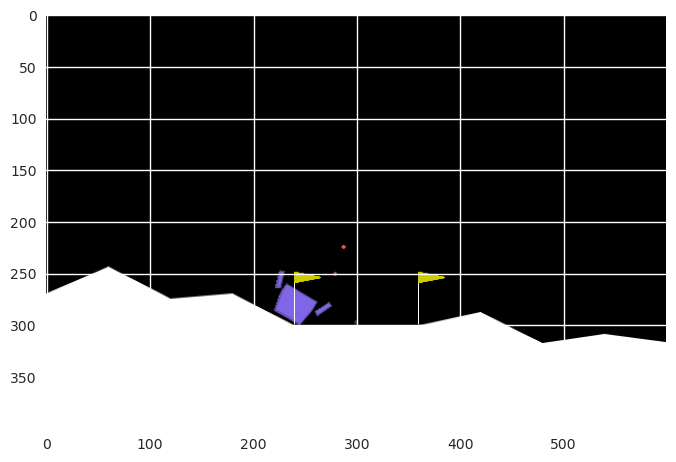

In [13]:
env.reset ()
img = plt.imshow(env.render()) # initialize bitmap embedding
for e in range (201):
  img.set_data(env.render()) # updating the data
  display.display(plt.gcf())
  display.clear_output(wait=True)
  a = env.action_space.sample() # random action choice
  # a = 2 # constant action choice
  obs, rew, done, _, _ = env.step(a) # taking action
  if done and (e + 1) < 200:
    print('*** FAILED ***')
    break

With random actions it is unspurprising that the agent doesn't manage to safely land between the flagpoles.

# Setting Seeds

In [14]:
def set_seeds(seed=100):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_random_seed(seed)
    # env.seed(seed)

set_seeds()

# Q Learning

In [40]:
from collections import deque
import time

class DQNAgent:
  def __init__(self):
    self.epsilon = 1.0
    self.epsilon_min = 0.01
    self.epsilon_decay = 0.995
    self.gamma = 0.95
    self.batch_size = 128
    self.max_treward = -1e6
    self.averages = list()
    self.memory = deque(maxlen=2000)
    self.osn = env.observation_space.shape[0]
    self.model = self.create_model()
    self.avg_time_per_episode = 0.0

  def create_model(self):
    model = Sequential()
    model.add(Dense(1024, input_dim=self.osn, activation='relu'))
    # model.add(Dense(128, activation='relu'))
    model.add(Dense(env.action_space.n, activation='linear'))
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.001))
    return model

  def act(self, state):
    return env.action_space.sample() if np.random.rand() <= self.epsilon else np.argmax(self.model.predict(state, verbose=0))
  
  def replay(self):
    print("Performing replay")
    batch = random.sample(self.memory, self.batch_size)
    for state, action, reward, next_state, done in batch:
      # Reward design
      reward -= np.mean((state[:1]) ** 2) # Reward based on distance to center (center is at 300)
      if not done:
        reward += self.gamma * np.amax(self.model.predict(next_state, verbose=0)[0])
      target = self.model.predict(state, verbose=0)
      target[0, action] = reward
      self.model.fit(state, target, epochs=1, verbose=False)
    if self.epsilon > self.epsilon_min:
      self.epsilon *= self.epsilon_decay
    print("Finished replay")

  def learn(self, episodes):
    trewards = []
    self.actions = []
    episode_times = []
    for e in range(1, episodes+1):
      start_time = time.time()
      state = env.reset()[0]
      state = np.reshape(state, [1, self.osn])
      treward = 0
      for _ in range(5000):
        action = self.act(state)
        self.actions.append(action)
        next_state, reward, done, truncated, info = env.step(action)
        next_state = np.reshape(next_state, [1, self.osn])
        self.memory.append([state, action, reward, next_state, done])
        state = next_state
        treward += float(reward)
        if done or truncated:
          trewards.append(treward)
          av = sum(trewards[-25:]) / 25 
          self.averages.append(av)
          self.max_treward = max(self.max_treward, treward)
          print('Episode: {}/{},\ttreward: {},\tav: {:.2f},\tmax_r: {:2},\tavg_time: {:.2f}'.format(e,episodes, treward, av, self.max_treward, self.avg_time_per_episode))
          break
      if len(self.memory) > self.batch_size:
        self.replay()
      end_time = time.time()
      episode_times.append(end_time - start_time)
      self.avg_time_per_episode = np.mean(episode_times)
      if treward > 200:
        break

  def test(self, episodes=100):
    trewards = []
    for e in range(1, episodes+1):
      print(f"{e=}")
      state = env.reset()[0]
      treward = 0
      for timestep in range(1001):
        state = np.reshape(state, [1, self.osn])
        action = np.argmax(self.model.predict(state, verbose=0)[0])
        next_state, reward, done, truncated, info = env.step(action)
        state = next_state
        treward += reward
        if done or truncated or state[0] >= 0.5:
          trewards.append(treward)
          print('Episode: {}/{}, treward: {}, position: {}'.format(e, episodes, treward, state[0]))
          break
    return trewards

agent = DQNAgent()

In [54]:
%time agent.learn(1000)

Episode: 1/1000,	treward: -270.67867376767185,	av: -10.83,	max_r: 239.17258926730136,	avg_time: 49.68
Performing replay
Finished replay
Episode: 2/1000,	treward: -101.0480751438651,	av: -14.87,	max_r: 239.17258926730136,	avg_time: 22.80
Performing replay
Finished replay
Episode: 3/1000,	treward: -366.3840613141653,	av: -29.52,	max_r: 239.17258926730136,	avg_time: 22.74
Performing replay
Finished replay
Episode: 4/1000,	treward: -89.64928424975915,	av: -33.11,	max_r: 239.17258926730136,	avg_time: 26.34
Performing replay
Finished replay
Episode: 5/1000,	treward: -309.91030674298315,	av: -45.51,	max_r: 239.17258926730136,	avg_time: 33.21
Performing replay
Finished replay
Episode: 6/1000,	treward: 2.088191719600971,	av: -45.42,	max_r: 239.17258926730136,	avg_time: 31.46
Performing replay
Finished replay
Episode: 7/1000,	treward: -225.34216271053208,	av: -54.44,	max_r: 239.17258926730136,	avg_time: 30.76
Performing replay
Finished replay
Episode: 8/1000,	treward: -340.54272876036896,	av: -6

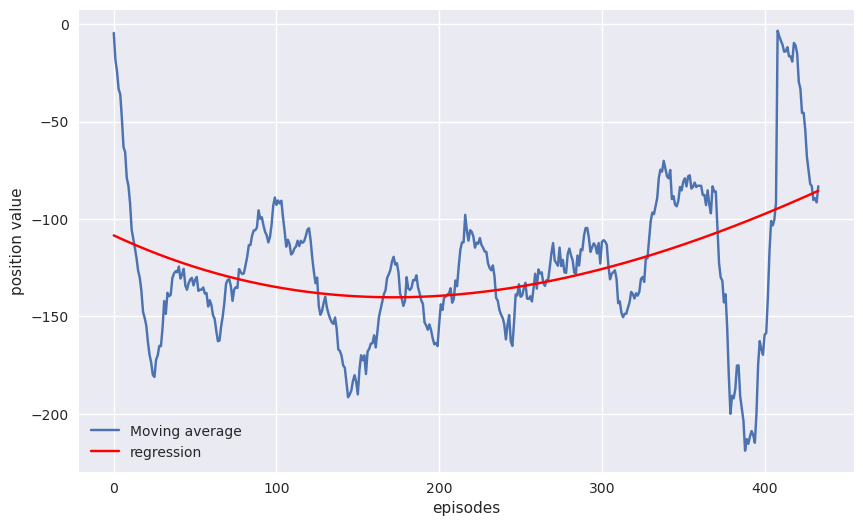

In [55]:
plt.figure(figsize=(10, 6))
x = range(len(agent.averages))
y = np.polyval(np.polyfit(x, agent.averages, deg=3), x)
plt.plot(agent.averages, label='Moving average')
plt.plot(x, y, 'r-', label='regression')
plt.xlabel('episodes')
plt.ylabel('position value')
plt.legend()

Based on the plot we can get a sense of whether the agent has reliably/incrementally "learned"/improved it's performance, or if it simply completed the task as a fluke.

# Testing the Agent

We test the agent to test if it has really "learned" the ability to land the craft.

In [58]:
trewards, tpositions = agent.test(100)

e=1


Episode: 1/100, treward: 144.35766952843602, position: -0.6597990989685059
e=2
Episode: 2/100, treward: -117.3434248130585, position: 0.5005353689193726
e=3
Episode: 3/100, treward: -17.84692047705424, position: 0.013492202386260033
e=4
Episode: 4/100, treward: 197.41498685070485, position: -0.30526596307754517
e=5
Episode: 5/100, treward: -19.390138442480563, position: 0.012556934729218483
e=6
Episode: 6/100, treward: 217.52962297578708, position: 0.3022462725639343
e=7
Episode: 7/100, treward: -212.7798093304628, position: -0.023509884253144264
e=8
Episode: 8/100, treward: -18.71483299464434, position: -0.0561765655875206
e=9
Episode: 9/100, treward: 191.72861234418934, position: -0.1722596138715744
e=10
Episode: 10/100, treward: -87.52850293938099, position: 0.5003715753555298
e=11
Episode: 11/100, treward: -178.94958998128004, position: 0.500779926776886
e=12
Episode: 12/100, treward: -138.77747808097934, position: 0.5002643465995789
e=13
Episode: 13/100, treward: -193.566530244789

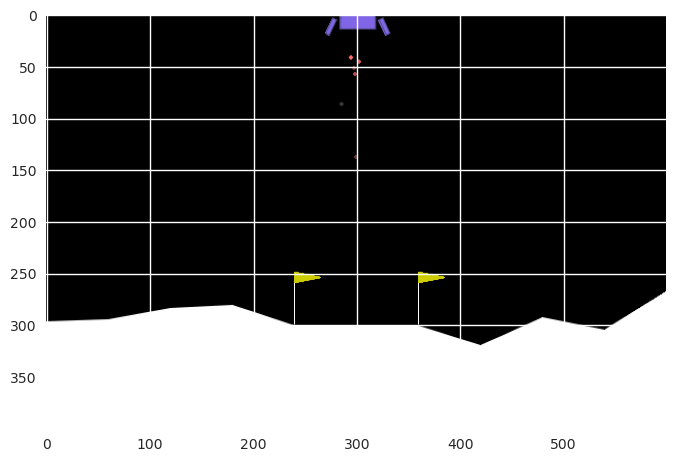

In [56]:
state, _ = env.reset(seed=202)
img = plt.imshow(env.render()) # initialize bitmap embedding
for e in range (5001):
  img.set_data(env.render())  # updating the data
  display.display(plt.gcf())
  display.clear_output(wait=True)
  state = np.reshape(state, [1, agent.osn] )
  a = np.argmax(agent.model.predict(state, verbose=0))  # learned action
  state, reward, done, truncate, info = env.step(a)
  if done and (e + 1) < 200:
    print(f'*** SUCCESS {e} ***')
    break
  elif done:
    print('*** FAILED ***')
    break

# An Improved Model

In [21]:
from keras.layers import Dense, Activation, Input
from keras.models import Sequential, load_model
from keras.optimizers import Adam
import numpy as np


class ReplayBuffer(object):
  def __init__(self, max_size, input_shape, n_actions, discrete=False):
    self.mem_size = max_size
    self.discrete = discrete
    self.mem_cntr = 0
    self.state_memory = np.zeros((self.mem_size, input_shape))
    self.new_state_memory = np.zeros((self.mem_size, input_shape))
    self.action_memory = np.zeros((self.mem_size, n_actions), dtype=np.int8 if self.discrete else np.float32)
    self.reward_memory = np.zeros(self.mem_size)
    self.terminal_memory = np.zeros(self.mem_size, dtype=np.float32)

  def store_transition(self, state, action, reward, state_, done):
    index = self.mem_cntr % self.mem_size
    self.state_memory[index] = state
    self.new_state_memory[index] = state_
    self.reward_memory[index] = reward
    self.terminal_memory[index] = 1 - int(done)
    if self.discrete:
      # One hot encoding
      actions = np.zeros(self.action_memory.shape[1])
      actions[action] = 1.0
      self.action_memory[index] = actions
    else:
      self.action_memory[index] = action
    self.mem_cntr += 1

  def sample_buffer(self, batch_size):
    max_mem = min(self.mem_cntr, self.mem_size)
    batch = np.random.choice(max_mem, batch_size)
    return self.state_memory[batch], self.action_memory[batch], self.reward_memory[batch], self.new_state_memory[batch], self.terminal_memory[batch]


def build_dqn(learning_rate, n_actions, input_dims, fc1_dims, fc2_dims):
  model = Sequential([
      Input(shape=(input_dims,)),
      Dense(fc1_dims),
      Activation('relu'),
      Dense(fc2_dims),
      Activation('relu'),
      Dense(n_actions)
  ])
  model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
  return model


class Agent(object):
  def __init__(self, alpha, gamma, n_actions, epsilon, batch_size, input_dims, epsilon_dec=0.996, epsilon_end=0.01, mem_size=1000000, fname='dqn_model.h5'):
    self.action_space = [i for i in range(n_actions)]
    self.n_actions = n_actions
    self.gamma = gamma
    self.epsilon = epsilon
    self.epsilon_dec = epsilon_dec
    self.epsilon_min = epsilon_end
    self.batch_size = batch_size
    self.model_file = fname

    self.memory = ReplayBuffer(mem_size, input_dims, n_actions, discrete=True)
    self.q_eval = build_dqn(alpha, n_actions, input_dims, 256, 256)

  def remember(self, state, action, reward, new_state, done):
    self.memory.store_transition(state, action, reward, new_state, done)


  def choose_action(self, state):
    state = state[np.newaxis, :]
    action = np.random.choice(self.action_space) if np.random.random() < self.epsilon else np.argmax(self.q_eval.predict(state, verbose=False))
    return action
  
  def learn(self):
    if self.memory.mem_cntr > self.batch_size:
      state, action, reward, new_state, done = self.memory.sample_buffer(self.batch_size)
      action_values = np.array(self.action_space, dtype=np.int8)
      action_indices = np.dot(action, action_values)
      q_next = self.q_eval.predict(new_state, verbose=False)
      q_eval = self.q_eval.predict(state, verbose=False)
      q_target = q_eval.copy()
      batch_index = np.arange(self.batch_size, dtype=np.int32)
      q_target[batch_index, action_indices] = reward + self.gamma * np.max(q_next, axis=1) * done
      _ = self.q_eval.fit(state, q_target, verbose=False)
      self.epsilon = self.epsilon * self.epsilon_dec if self.epsilon > self.epsilon_min else self.epsilon

  def save_model(self):
    self.q_eval.save(self.model_file)

  def load_model(self):
    self.q_eval = load_model(self.model_file)

In [22]:
import gym
import time  # Import the time module

env = gym.make('LunarLander-v2')
n_episodes = 500
agent = Agent(gamma=0.99, epsilon=1.0, alpha=0.0005, input_dims=8,
              n_actions=4, mem_size=int(1e6), batch_size=64, epsilon_end=0.01)

# agent.load_model()
scores = []
eps_history = []
averages = []

for i in range(n_episodes):
  start_time = time.time()  # Record the start time of the episode

  done = False
  score = 0
  observation, _ = env.reset()
  while not done:
    action = agent.choose_action(observation)
    observation_, reward, done, truncated, info = env.step(action)
    score += reward
    agent.remember(observation, action, reward, observation_, int(done))
    observation = observation_
    agent.learn()
  eps_history.append(agent.epsilon)
  scores.append(score)

  end_time = time.time()  # Record the end time of the episode
  episode_time = end_time - start_time  # Calculate the duration of the episode

  averages.append(np.mean(scores[-25:]))
  print(f'Episode: {i}, score: {score:.2f}, average score: {averages[-1]:.2f}, epsilon: {"{:.2g}".format(agent.epsilon)}, time: {episode_time:.2f}')

  if i % 10 == 0:
    agent.save_model()

/root/miniconda3/envs/qfc/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode: 0, score: -178.99, average score: -178.99, epsilon: 0.88, time: 5.42
Episode: 1, score: -123.36, average score: -151.17, epsilon: 0.57, time: 16.28
Episode: 2, score: -125.05, average score: -142.47, epsilon: 0.26, time: 31.26
Episode: 3, score: 4.53, average score: -105.72, epsilon: 0.14, time: 27.88
Episode: 4, score: -83.20, average score: -101.21, epsilon: 0.087, time: 21.90
Episode: 5, score: -489.25, average score: -165.89, epsilon: 0.065, time: 12.92
Episode: 6, score: -249.61, average score: -177.85, epsilon: 0.041, time: 19.90
Episode: 7, score: -147.35, average score: -174.03, epsilon: 0.029, time: 16.34
Episode: 8, score: -508.01, average score: -211.14, epsilon: 0.022, time: 12.63
Episode: 9, score: -265.88, average score: -216.62, epsilon: 0.016, time: 14.83


Episode: 10, score: -224.53, average score: -217.34, epsilon: 0.01, time: 17.61
Episode: 11, score: -310.35, average score: -225.09, epsilon: 0.01, time: 45.88
Episode: 12, score: -190.76, average score: -222.45, epsilon: 0.01, time: 23.43


In [ ]:
filename = 'lunar_lander.png'
x = [i+1 for i in range(num_episodes)]
plot_learning_curve(x, scores, eps_history, filename)

NameError: name 'plot_learning_curve' is not defined